In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [2]:
# Load dataset
df = pd.read_csv("adult 3(1).csv")

# View basic info
print(df.head())
print(df.info())


   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country incom

In [3]:
# Convert income to approximate numeric salary
df['income'] = df['income'].map({
    '<=50K': 40000,
    '>50K': 70000
})


In [4]:
# Replace '?' with NaN
df.replace(' ?', np.nan, inplace=True)

# Drop rows with any NaN
df.dropna(inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)


In [5]:
# Features and target
X = df.drop('income', axis=1)
y = df['income']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

# Define preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [6]:
# Features and target
X = df.drop('income', axis=1)
y = df['income']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

# Define preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


In [7]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model pipelines
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Train both models
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [8]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return rmse, r2

lr_rmse, lr_r2 = evaluate(lr_pipeline, X_test, y_test)
rf_rmse, rf_r2 = evaluate(rf_pipeline, X_test, y_test)

print("Linear Regression -> RMSE:", lr_rmse, " | R²:", lr_r2)
print("Random Forest     -> RMSE:", rf_rmse, " | R²:", rf_r2)


Linear Regression -> RMSE: 10098.26319123248  | R²: 0.3686472662920135
Random Forest     -> RMSE: 9351.373378377542  | R²: 0.45858599009350387


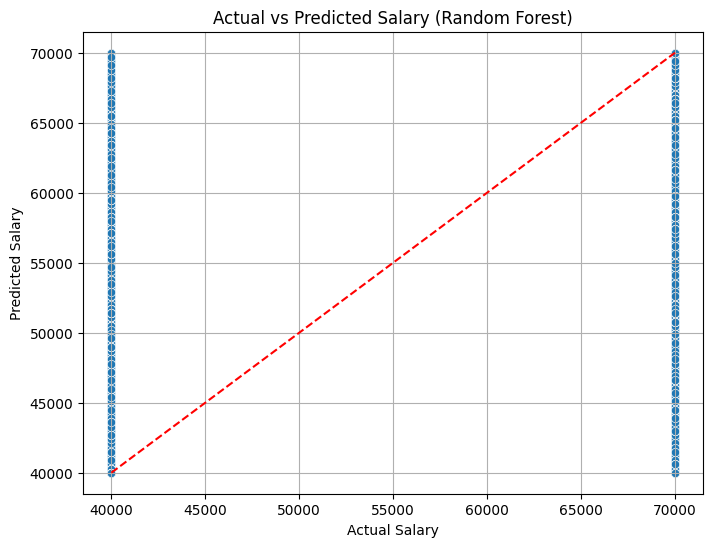

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test data using best model (Random Forest)
y_pred = rf_pipeline.predict(X_test)

# Actual vs Predicted Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary (Random Forest)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.grid(True)
plt.show()


In [10]:
joblib.dump(rf_pipeline, "salary_predictor.pkl")


['salary_predictor.pkl']